In [1]:
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

%matplotlib inline

import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
with open('ready.pkl', 'rb') as handle:
    df = pickle.load(handle) 

In [3]:
#dropping the fem+gun feature I engineered because it was hurting model performance
df = df.drop(['fem+gun'],axis=1)

In [4]:
#pasting this over from the eda worksheet
def plot_feature(df,column,answer=1):
    """
    Purpose: Show distribution of voting between republians and democrats for the feature inputed
    Arguments: dataframe with the features and column name
    Returns: Bar plot for distribution for the particular feature, and percentage split between two groups
    """
    mask = df[column] == answer
    
    #assigning varibales 
    if df[mask].party.value_counts().index[0] == 'Democrat':
        amount_dem = df[mask].party.value_counts()[0]
        amount_rep = df[mask].party.value_counts()[1]
    else:
        amount_dem = df[mask].party.value_counts()[1]
        amount_rep = df[mask].party.value_counts()[0]
    
    #plotting the bar graph
    plt.bar(['Democrat','Republican'], [amount_dem,amount_rep])
    
    #printing the percentages of republicans and democrats in this group
    print('Democrats: ' + str(100*(amount_dem/(amount_dem+amount_rep))))
    print('Republicans: ' + str(100*(amount_rep/(amount_dem+amount_rep))))
    
    return df[mask].party.value_counts()

In [5]:
#pasting this over from the model selection worksheet

def enhanced_confusion_matrix(model, x_train, x_test, y_train, y_test, no_auc=False):
    """
    Purpose: makes a confusion matrix and reports on precision and recall for the given model
    Arguments: model, xtrain data, ytrain data, xtest data, and ytest datasets already separated
    Returns: Confusion matrix and precision and recall scores    
    """
    
    #generate all the metrics
    fitted_model = model.fit(x_train,y_train)
    prediction_hard = fitted_model.predict(x_test)
    conf_matrix = confusion_matrix(y_test, prediction_hard)   
    cross_val = cross_val_score(model,x_train,y_train,cv=5)
    
    #print all the metrics
    print('Precision: ' + str(int((conf_matrix[0][0]) / (conf_matrix[0][0] + conf_matrix[1][0])*100)) + '%')
    print('Recall: ' + str(int((conf_matrix[0][0]) / (conf_matrix[0][0] + conf_matrix[0][1])*100)) + '%')
    print('Train Accuracy: ' + str(100*(fitted_model.score(x_train, y_train))) + '%')
    print('Test Accuracy: ' + str(100*(fitted_model.score(x_test, y_test))) + '%')
    print('Mean CV Score: ' + str(100*(np.mean(cross_val))) + '%')
    
    #for non linear models do the following:
    if no_auc ==False:
        test_score = model.predict_proba(x_test)
        auc = roc_auc_score(y_test,test_score[:,1])
        ll = log_loss(y_test, test_score)
        print('AUC Score: ' + str(100*(auc)) + '%')
        print('Log Loss: ' + str(ll))
        
    #finally print the actual confusion matrix
    print(confusion_matrix(y_test, prediction_hard))
    
    return fitted_model

Ok so we're down to three models:
1. Naive Bayes Bernoulli
1. Logistic Regression
1. Random Forest

I want to see if I can tune them individually in order to give our ensemble model the best AUC score possible. Let's start with Logistic Regression:

## Logistic Regression Tuning:

Initially C = 1000 for this model

In [7]:
#load in lr model:

with open('models/log_regres_fitted.pkl', 'rb') as handle:
    fitted_lr = pickle.load(handle)

In [8]:
X_all = df.drop(['party'],axis=1)
y_all = df.party
x_tr, x_te, y_tr, y_te = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all,random_state=42)
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = imp.fit(x_tr)
X_train_imp = imp.transform(x_tr)
X_test_imp = imp.transform(x_te)

In [9]:
coeff_list = list(zip(abs(fitted_lr.coef_[0]),x_tr.columns))
coeff_list.sort(reverse=True)
coeff_list

[(1.2683022702045696, 'q109244'),
 (0.625046982209474, 'householdstatus_Domestic Partners (no kids)'),
 (0.4257876596614737, 'q115611'),
 (0.39931401114401743, 'q98869'),
 (0.34153835153301554, 'q113181'),
 (0.3179864224303649, 'q98197'),
 (0.31229057566933477, 'q99480'),
 (0.2767059502709071, 'q116881'),
 (0.26534145257686315, 'q98059'),
 (0.2644144730981662, "educationlevel_Master's Degree"),
 (0.2565904751730365, 'q122771'),
 (0.23650961394596898, 'income_$75,000 - $100,000'),
 (0.2191140896780676, 'q115390'),
 (0.21850074001218317, 'q115899'),
 (0.21829595434086227, 'householdstatus_Married (w/kids)'),
 (0.2099147453521228, 'q101163'),
 (0.20431094765882885, 'q118232'),
 (0.1925173491803637, 'q116953'),
 (0.1702088228382569, 'q122120'),
 (0.16580134036485167, 'householdstatus_Domestic Partners (w/kids)'),
 (0.16234872741387055, 'q112512'),
 (0.1618235756739876, 'q104996'),
 (0.15527929930398204, 'householdstatus_Single (w/kids)'),
 (0.15493708400980896, 'q119851'),
 (0.154771735602

In [10]:
c_range = list(range(1, 1001))
param_grid = {'C': c_range}
param_grid

{'C': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

In [11]:
lr = LogisticRegression()
grid = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_imp, y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                               15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
                               27, 28, 29, 30, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [12]:
#best param:
grid.best_params_

{'C': 1}

In [13]:
#best CV score
grid.best_score_

0.6057476425684778

In [14]:
#running this best model to get all the stats for it:
lr_best = LogisticRegression(solver= 'liblinear', C=1)
best_fitted_lr = enhanced_confusion_matrix(lr_best,X_train_imp, X_test_imp, y_tr, y_te)

Precision: 64%
Recall: 67%
Train Accuracy: 64.95285136955545%
Test Accuracy: 62.74685816876122%
Mean CV Score: 60.573833993914285%
AUC Score: 66.88381420623625%
Log Loss: 0.6543354275951458
[[396 194]
 [221 303]]


In [15]:
coeff_list = list(zip(abs(best_fitted_lr.coef_[0]),x_tr.columns))
coeff_list.sort(reverse=True)
coeff_list

[(1.2565023512407425, 'q109244'),
 (0.6068907210481936, 'householdstatus_Domestic Partners (no kids)'),
 (0.42479763152507916, 'q115611'),
 (0.39632805988853326, 'q98869'),
 (0.3404152320523023, 'q113181'),
 (0.31724581254355827, 'q98197'),
 (0.3090864421082988, 'q99480'),
 (0.274659168937087, 'q116881'),
 (0.2600911592694424, "educationlevel_Master's Degree"),
 (0.2570708752555143, 'q98059'),
 (0.25299210959052565, 'q122771'),
 (0.23428404559487587, 'income_$75,000 - $100,000'),
 (0.21737319593566032, 'householdstatus_Married (w/kids)'),
 (0.2173335373318406, 'q115390'),
 (0.21713850855900088, 'q115899'),
 (0.20889235721154115, 'q101163'),
 (0.2034905263861126, 'q118232'),
 (0.19120478567840063, 'q116953'),
 (0.16856716020755322, 'q122120'),
 (0.16075746963351564, 'q104996'),
 (0.15953416201842763, 'householdstatus_Domestic Partners (w/kids)'),
 (0.15933994593715045, 'q112512'),
 (0.15397327970409344, 'q119851'),
 (0.1524143102441265, 'q108856'),
 (0.15122220387059016, 'householdstatu

**Well the Grid Search found a C value that increased our AUC but by very little. Now we have the "best" logistic regression model:**

## Random Forest Tuning:

Initial number of tress = 100 in this model

In [11]:
#load in rf model:

with open('random_forest.pkl', 'rb') as handle:
    fitted_rf = pickle.load(handle)

In [12]:
tree_range = list(range(1, 151))
param_grid = {'n_estimators': tree_range}
param_grid

{'n_estimators': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150]}

In [ ]:
rf = RandomForestClassifier()
grid = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_imp, y_tr)

In [ ]:
#best param:
grid.best_params_

In [ ]:
#running this best model to get all the stats for it:
rf_best = RandomForestClassifier(n_estimators=88)
best_fitted_rf = enhanced_confusion_matrix(rf_best,X_train_imp, X_test_imp, y_tr, y_te)

Technically, this model has a slightly worse AUC score but the output is different everytime. I still need to reduce overfitting though. Let's see if I can do that by reducing the feature count:

In [ ]:
#feature importance
feature_imp = list(zip(best_fitted_rf.feature_importances_,x_tr.columns))
feature_imp.sort(reverse=True)
feature_imp

In [ ]:
#grabbing only the top 15 features
top_15_features = []
for feature in feature_imp:
    if feature[1] != 'q98197': #this is a duplicate question that I don't want in my new df
        column_name = feature[1]
        top_15_features.append(column_name)
top_15_features = top_15_features[0:15]
top_15_features.append('party')

In [ ]:
small_df = df[top_15_features]

Running this model with only the top 15 features

In [ ]:
X = small_df.drop(['party'],axis=1)
y = small_df.party
X_tr, X_te, Y_tr, Y_te = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = imp.fit(X_tr)
x_train_imp = imp.transform(X_tr)
x_test_imp = imp.transform(X_te)

In [ ]:
rf_best = RandomForestClassifier(n_estimators=88)
small_best_rf = enhanced_confusion_matrix(rf_best,x_train_imp, x_test_imp, Y_tr, Y_te)

Even with only 15 features the model is still overfitting by a lot and the AUC score went down by 3 points. I'm not sure reducing features is the way to cure overfitting. Let's try optimizing some hyperparameters with RandomizedSearchCV. The following code is mostly taken from Will Koehrsen's blog post on Towards Data Science:https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [13]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 1500, num = 30)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [14]:
#creating the grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [15]:
print(random_grid)

{'n_estimators': [1, 52, 104, 156, 207, 259, 311, 362, 414, 466, 517, 569, 621, 672, 724, 776, 828, 879, 931, 983, 1034, 1086, 1138, 1189, 1241, 1293, 1344, 1396, 1448, 1500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [19]:
new_rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = new_rf, param_distributions = 
                               random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [20]:
rf_random.fit(X_train_imp, y_tr)
rf_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 16.8min finished


{'n_estimators': 1293,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

In [21]:
random_rf_model = rf_random.best_estimator_
random_rf = enhanced_confusion_matrix(random_rf_model,X_train_imp, X_test_imp, y_tr, y_te)

Precision: 63%
Recall: 68%
Train Accuracy: 99.86528962730131%
Test Accuracy: 62.11849192100538%
Mean CV Score: 62.99901083920499%
AUC Score: 65.41628930003883%
Log Loss: 0.6574939545636768
[[403 187]
 [235 289]]


**^this "best estimator" that this randomized search CV spat out is actually not the best one I found. I had run this earlier but had forgotten to do a random seed so I can't reproduce that here but luckily I pickled the model and will run it below to show results**

**First, I will use a grid search to search around the parameters that my original random search found to see if I can optimize any more**

In [23]:
# Create the parameter grid based on the results of my original random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [9, 10, 11],
    'max_features': [10, 20, 'auto'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [440, 466, 480]
}

rf3 = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf3, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

#Fit the model
grid_search.fit(X_train_imp, y_tr)

#Print out best parameters
grid_search.best_params_

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed: 10.1min finished


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 440}

In [25]:
rf_grid = grid_search.best_estimator_
grid_rf = enhanced_confusion_matrix(rf_grid,X_train_imp, X_test_imp, y_tr, y_te)

Precision: 62%
Recall: 75%
Train Accuracy: 86.10237988325102%
Test Accuracy: 63.28545780969479%
Mean CV Score: 62.909098599799115%
AUC Score: 67.60188898951999%
Log Loss: 0.6491882731269121
[[443 147]
 [262 262]]


**This is similar to the results shown by my original randomized search tuned RF model but still not as good. I'm going to load that model in now:**

In [26]:
with open('random_search_rf_model.pkl', 'rb') as handle:
    rf_random_model_orig = pickle.load(handle)

In [27]:
rf_random_model_orig

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=466,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [28]:
rf_rand_orig = enhanced_confusion_matrix(rf_random_model_orig,X_train_imp, X_test_imp, y_tr, y_te)

Precision: 62%
Recall: 75%
Train Accuracy: 84.14907947911989%
Test Accuracy: 62.74685816876122%
Mean CV Score: 62.43779283007714%
AUC Score: 68.10421788070902%
Log Loss: 0.6486623057514272
[[445 145]
 [270 254]]


**Ah yes here we go. This is the best Random Forest model I have gotten**

## Final Ensemble Model:

In [32]:
nb = BernoulliNB()
voting = VotingClassifier(estimators=[('lr', best_fitted_lr), ('rf', rf_random_model_orig), ('NBB', nb)], voting='soft')
ensemble_fitted = enhanced_confusion_matrix(voting,X_train_imp, X_test_imp, y_tr, y_te)

Precision: 63%
Recall: 70%
Train Accuracy: 67.64705882352942%
Test Accuracy: 62.92639138240575%
Mean CV Score: 61.98888359021713%
AUC Score: 67.56921982145168%
Log Loss: 0.6469073672171282
[[414 176]
 [237 287]]


**While the recall, AUC, and test accuracy are lower here than in the Random Forest model by itself, I've decided to choose this model because it is not as overfit as the Random Forest model. Ultimately, I think it matters more to pick the model that will generalize better.**

In [33]:
#with open('final_ensemble.pkl', 'wb') as f:
    #pickle.dump(ensemble_fitted, f)

In [50]:
#with open('final_random_forest.pkl', 'wb') as f:
    #pickle.dump(rf_random_model_orig, f)

# Plots

**Let's look at the ROC-AUC curves for all final models:**

In [77]:
with open('models/naive_bayes_fitted.pkl', 'rb') as f:
    nb = pickle.load(f)

AUC scores: 

Logistic Regression =  0.6688381420623626
Naive Bayes =  0.667605770474835
Random Forest =  0.6810421788070902
Ensemble =  0.6756921982145168


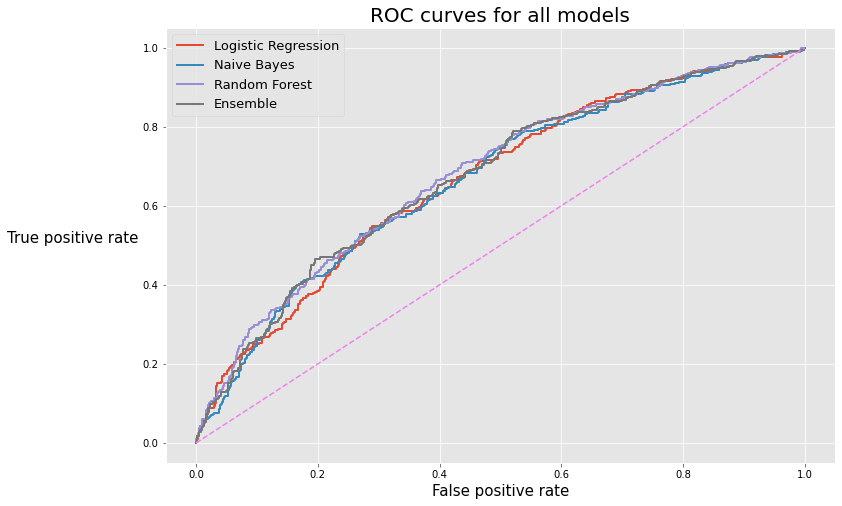

In [88]:
#massive amount of code that just plots the ROC curves for all the best models

fpr, tpr, thresholds = roc_curve(y_te, lr_best.predict_proba(X_test_imp)[:,1],pos_label='Republican')
fpr2, tpr2, thresholds2 = roc_curve(y_te, nb.predict_proba(X_test_imp)[:,1],pos_label='Republican')
fpr3, tpr3, thresholds3 = roc_curve(y_te, rf_rand_orig.predict_proba(X_test_imp)[:,1],pos_label='Republican')
fpr4, tpr4, thresholds4 = roc_curve(y_te, ensemble_fitted.predict_proba(X_test_imp)[:,1],pos_label='Republican')

plt.figure(figsize=(12,8))
plt.plot(fpr, tpr,lw=2)
plt.plot(fpr2, tpr2,lw=2)
plt.plot(fpr3, tpr3,lw=2)
plt.plot(fpr4, tpr4,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.legend(['Logistic Regression', 'Naive Bayes', 'Random Forest', 'Ensemble'], fontsize=13)
plt.xlabel('False positive rate',fontsize=15, color='black')
plt.xticks(fontsize=10, color='black')
plt.yticks(fontsize=10, color='black')
plt.ylabel('True positive rate',fontsize=15, rotation='horizontal', horizontalalignment='right', color='black')
plt.title('ROC curves for all models',fontsize=20);
plt.savefig('ROC_Curves.png',format='png',bbox_inches='tight')

print("AUC scores: \n")
print("Logistic Regression = ", roc_auc_score(y_te, lr_best.predict_proba(X_test_imp)[:,1]))
print("Naive Bayes = ", roc_auc_score(y_te, nb.predict_proba(X_test_imp)[:,1]))
print("Random Forest = ", roc_auc_score(y_te, rf_rand_orig.predict_proba(X_test_imp)[:,1]))
print("Ensemble = ", roc_auc_score(y_te, ensemble_fitted.predict_proba(X_test_imp)[:,1]))

Also lets make a chart for feature importances:

In [92]:
feature_imp = list(zip(rf_random_model_orig.feature_importances_,x_tr.columns))
feature_imp.sort(reverse=True)
feature_imp

[(0.09504902481032468, 'q109244'),
 (0.04280535842961647, 'yob'),
 (0.03620690754843635, 'q115611'),
 (0.026669342337267803, 'q113181'),
 (0.02225956162663306, 'q98197'),
 (0.017512253932753446, 'gender_Male'),
 (0.013477985875773027, 'q98869'),
 (0.012183915680550767, 'q101163'),
 (0.011756455038930712, 'q115899'),
 (0.011625233511738085, 'householdstatus_Married (w/kids)'),
 (0.010265000122794438, 'q99480'),
 (0.009881349907272002, 'q116881'),
 (0.009554724979567848, 'q118232'),
 (0.009237354178221574, 'q115195'),
 (0.009217863325303405, 'q115390'),
 (0.009073915002869096, 'q105655'),
 (0.008913541225700549, 'q114961'),
 (0.00880306642583106, 'q105840'),
 (0.00876100117585902, 'q120379'),
 (0.008745887568496404, 'q104996'),
 (0.00867654304098895, 'q118892'),
 (0.00848809874797554, 'q106042'),
 (0.00839652375249573, 'q119851'),
 (0.008381053813172789, 'q110740'),
 (0.008329372495719049, 'q98078'),
 (0.008276870422547112, 'q103293'),
 (0.008118463732607729, 'q116953'),
 (0.008054427027

In [101]:
importances_list = []
for x in feature_imp:
    if x[0] != 0.02225956162663306:
        importances_list.append(x[0])
feature_list = []
for x in feature_imp:
    if x[1] != 'q98197':
        feature_list.append(x[1])
    

In [109]:
feature_list[0:13] 
feat_list = ['Feminist', 'Birth Year', 'Gun', 'Pray', 'Gender', 'Purpose', 'Parent', 'Hardship', 'Married w/kids', 'Punishment', 'Happy/Right', 'Idealist?', 'City']

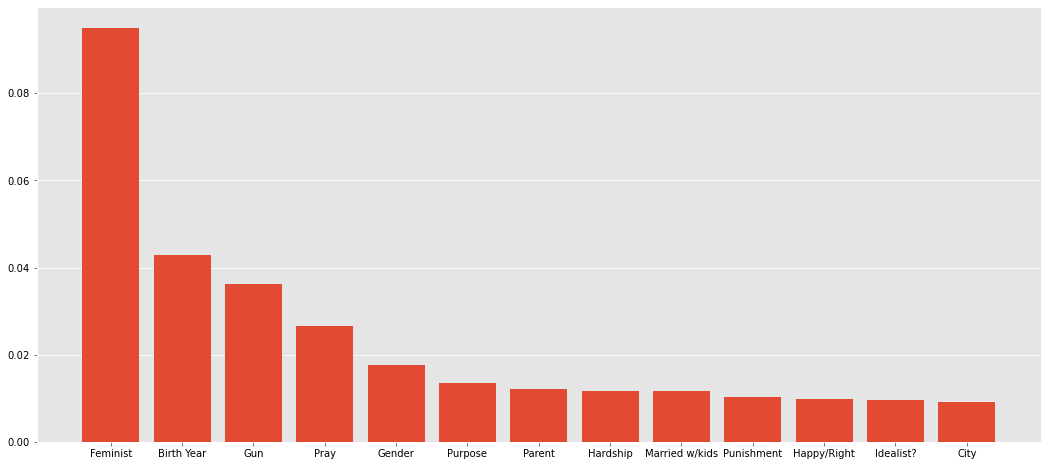

In [119]:
plt.figure(figsize=(18,8))
ax = plt.axes()        
ax.xaxis.grid(False) 
plt.xticks(fontsize=10, color='black')
plt.yticks(fontsize=10, color='black')
plt.bar(feat_list,importances_list[0:13])
plt.savefig('feature_importances.png',format='png',bbox_inches='tight')